Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob

import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import load_img

In [5]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [12]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [13]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

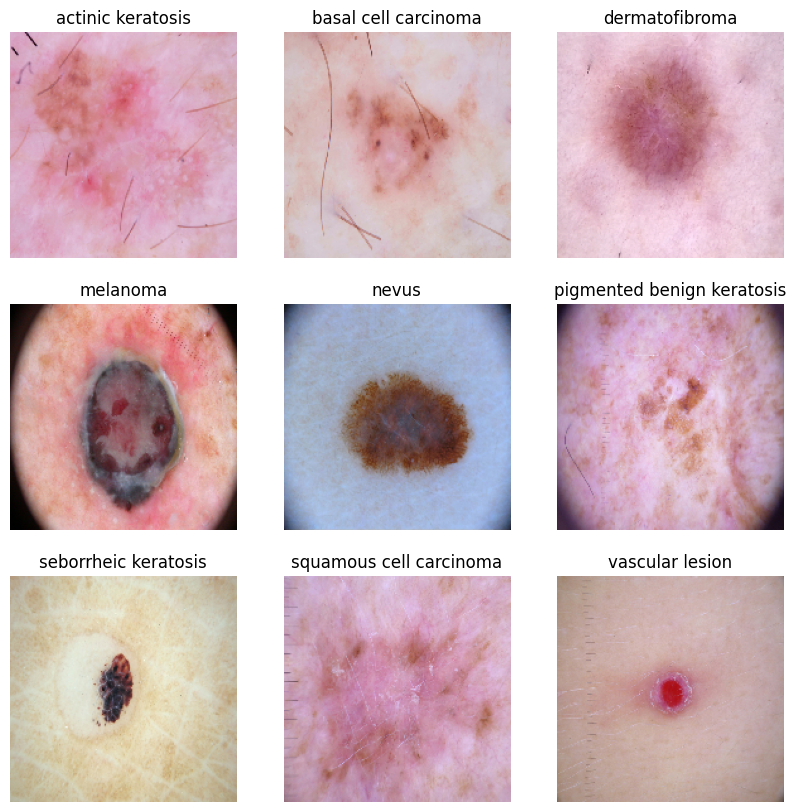

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(str(data_dir_train)+'/'+c+'/'+os.listdir(str(data_dir_train)+'/'+c)[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [17]:
input_shape = (180,180,3)
lr = 1e-5        #Define small learning rate , this is hyperparameter that controls the step size at which the optimizer adjusts the weights during training.
init = 'normal'  # init represents the weight initialization method for the neural network. 'normal' refers to the normal distribution initializer, which randomly initializes the weights from a Gaussian distribution with zero mean and a specified standard deviation.
activ = 'relu'

#Sequential allows you to create models layer-by-layer
model = Sequential()
#Rescaling Layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

#Second Convulation layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Third Convulation layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

model.add(Dense(128, activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


In [18]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
### Todo, choose an appropirate optimiser and loss function

# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)           

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)           

In [21]:
### Todo, choose an appropirate optimiser and loss function

#Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy is used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)           

### Train the model

In [23]:
epochs = 20
batch_size = 32

#Train the model
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 708s 891ms/step - loss: 2.3695 - accuracy: 0.2481 - val_loss: 1.5886 - val_accuracy: 0.3712
Epoch 2/20
169/169 [==============================] - 12s 73ms/step - loss: 1.4146 - accuracy: 0.4755 - val_loss: 1.3406 - val_accuracy: 0.4989
Epoch 3/20
169/169 [==============================] - 12s 74ms/step - loss: 1.2014 - accuracy: 0.5662 - val_loss: 1.1919 - val_accuracy: 0.5880
Epoch 4/20
169/169 [==============================] - 13s 74ms/step - loss: 1.0126 - accuracy: 0.6313 - val_loss: 1.0591 - val_accuracy: 0.6466
Epoch 5/20
169/169 [==============================] - 13s 77ms/step - loss: 0.8066 - accuracy: 0.7127 - val_loss: 0.9105 - val_accuracy: 0.6927
Epoch 6/20
169/169 [==============================] - 12s 74ms/step - loss: 0.6342 - accuracy: 0.7767 - val_loss: 0.8634 - val_accuracy: 0.7298
Epoch 7/20
169/169 [==============================] - 13s 74ms/step - loss: 0.5319 - accuracy: 0.8160 - val_loss: 0.9051 - val_accurac

### Visualizing training results

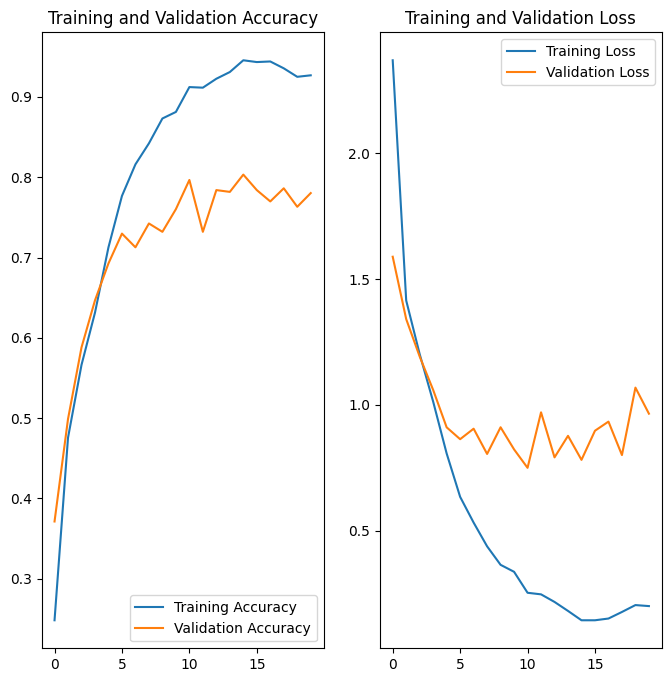

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 1s 19ms/step - loss: 0.9648 - accuracy: 0.7803
Accuracy:  0.9343471527099609
Validation Accuracy:  0.7802523970603943
Loss:  0.1763826310634613
Validation Loss 0.9648099541664124


#### There is a huge gap between the Training accuracy and the validation accuracy , which indicates that this model overfits.

### Write your findings here

In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = class_names,
    batch_size = 32
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = class_names,
    batch_size = 32
)

Found 6739 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


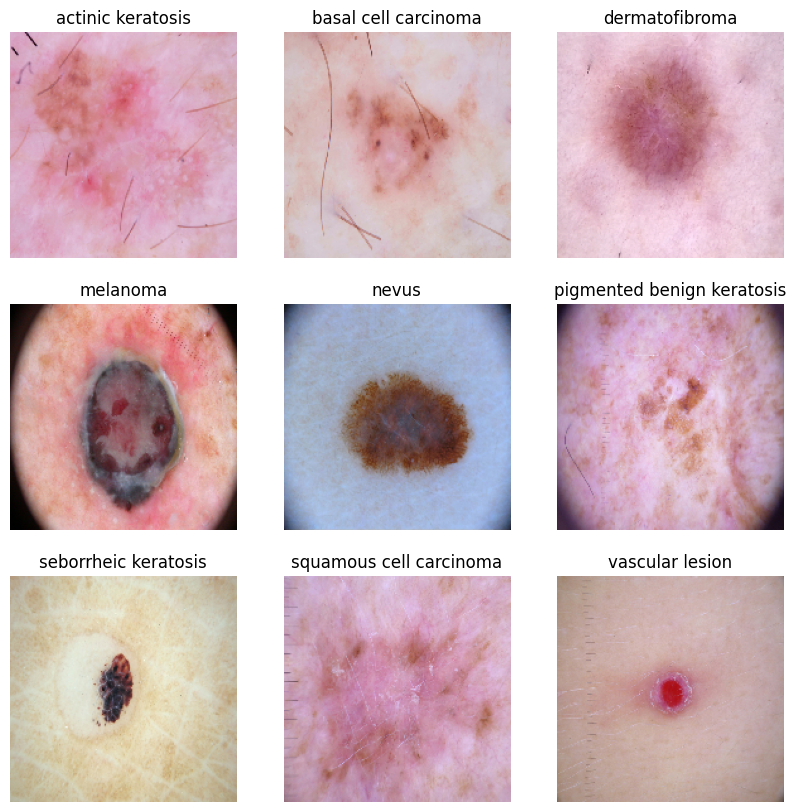

In [27]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10,10))

index = 0
for c in class_names:
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(str(data_dir_train)+'/'+c+'/'+os.listdir(str(data_dir_train)+'/'+c)[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here

input_shape = (180,180,3)
lr = 1e-5        #Define small learning rate , this is hyperparameter that controls the step size at which the optimizer adjusts the weights during training.
init = 'normal'  # init represents the weight initialization method for the neural network. 'normal' refers to the normal distribution initializer, which randomly initializes the weights from a Gaussian distribution with zero mean and a specified standard deviation.
activ = 'relu'

#Sequential allows you to create models layer-by-layer
model = Sequential()
#Rescaling Layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer before passing to second layer
model.add(Dropout(0.25))

#Second Convulation layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer before passing to third layer
model.add(Dropout(0.25))

#Third Convulation layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer before passing to flatten layer
model.add(Dropout(0.25))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_8 (ModuleWr  (None, 178, 178, 32)      896       
 apper)                                                          
                                                                 
 module_wrapper_9 (ModuleWr  (None, 89, 89, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_10 (ModuleW  (None, 89, 89, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_11 (ModuleW  (None, 87, 87, 64)        18496     
 rapper)                                              

### Compiling the model

In [29]:
## Your code goes here
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

### Training the model

In [30]:
## Your code goes here, note: train your model for 20 epochs
## Your code goes here, note: train your model for 20 epochs

epochs = 20
batch_size = 32

#Train the model
history = model.fit(
  train_batches,
  batch_size=batch_size,
  validation_data=valid_batches,
  epochs=epochs
)

Epoch 1/20
211/211 [==============================] - 167s 767ms/step - loss: 1.9208 - accuracy: 0.2710 - val_loss: 1.9647 - val_accuracy: 0.3220
Epoch 2/20
211/211 [==============================] - 135s 642ms/step - loss: 1.5650 - accuracy: 0.3996 - val_loss: 1.9604 - val_accuracy: 0.3390
Epoch 3/20
211/211 [==============================] - 131s 619ms/step - loss: 1.4555 - accuracy: 0.4447 - val_loss: 1.9582 - val_accuracy: 0.3390
Epoch 4/20
211/211 [==============================] - 133s 631ms/step - loss: 1.3939 - accuracy: 0.4701 - val_loss: 2.0871 - val_accuracy: 0.3898
Epoch 5/20
211/211 [==============================] - 129s 611ms/step - loss: 1.3368 - accuracy: 0.4889 - val_loss: 2.2176 - val_accuracy: 0.4068
Epoch 6/20
211/211 [==============================] - 130s 615ms/step - loss: 1.3239 - accuracy: 0.4987 - val_loss: 2.0837 - val_accuracy: 0.4068
Epoch 7/20
211/211 [==============================] - 130s 617ms/step - loss: 1.2643 - accuracy: 0.5165 - val_loss: 2.1896 -

### Visualizing the results

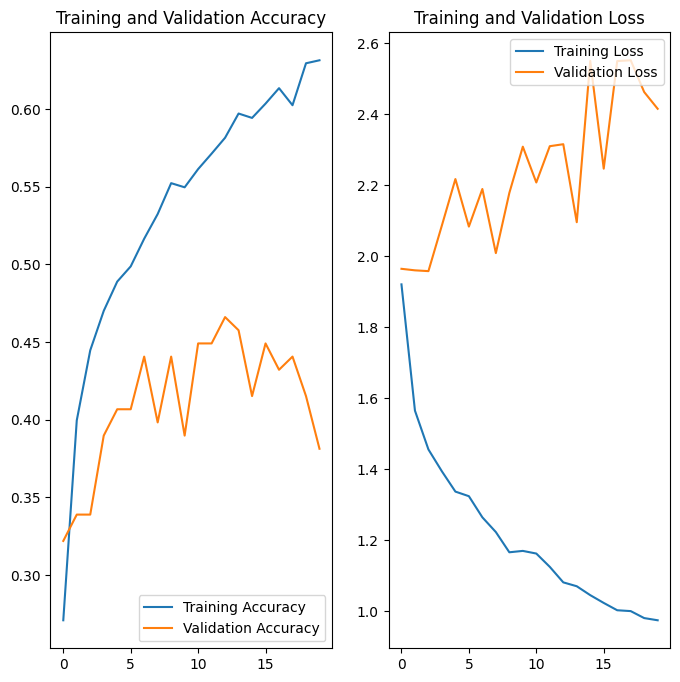

In [31]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### In first model ,training accuracy is higher than the validation accurancy indicating the model is overfitting . In the second model the validation accuracy increased an the gap between training and valiation decreased indicating its a better model

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #Name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,squamous cell carcinoma,181
2,seborrheic keratosis,77
3,pigmented benign keratosis,462
4,basal cell carcinoma,376
5,nevus,357
6,melanoma,438
7,actinic keratosis,114
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

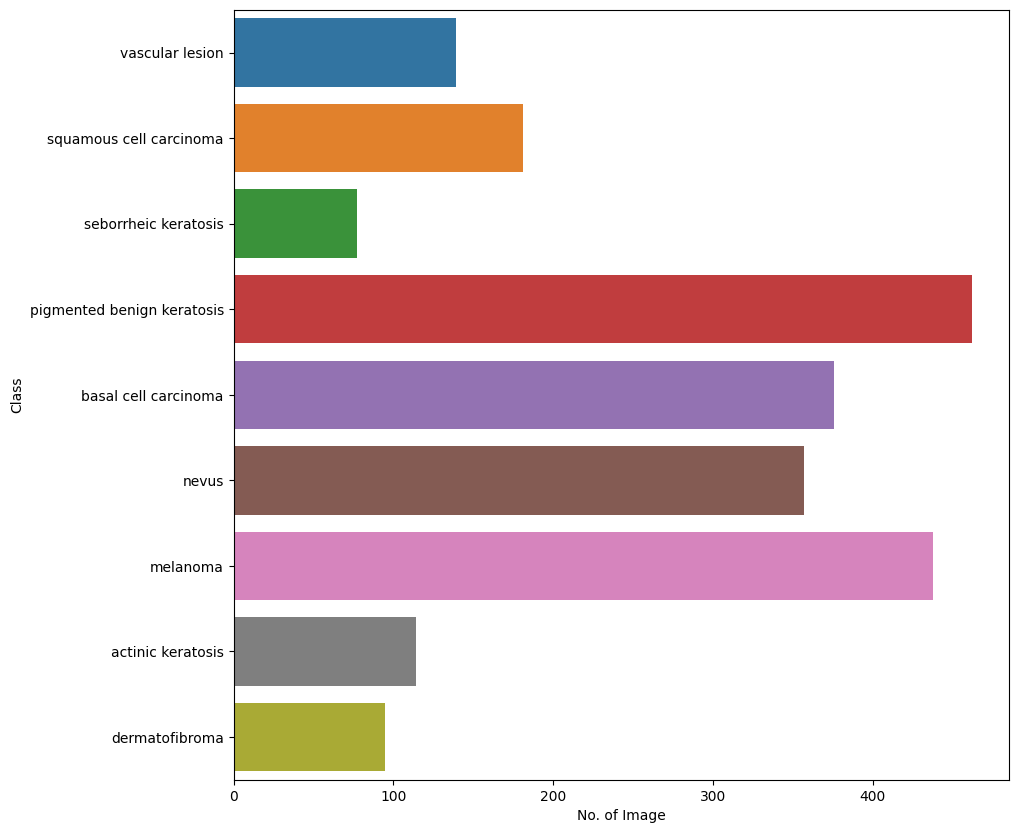

In [33]:
plt.figure(figsize=(10, 10))
sns.barplot(x="No. of Image", y="Class", data=df,label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
### Answer - Seborrheic Keratasis - it has 77 samples
#### - Which classes dominate the data in terms proportionate number of samples?
### Answer - Pigmented Benign Keratosis - it has 462 samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DE13D5BFCA0>: 100%|██████████| 500/500 [00:24<00:00, 20.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE13D407F70>: 100%|██████████| 500/500 [00:28<00:00, 17.53 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE13D6A81F0>: 100%|██████████| 500/500 [00:28<00:00, 17.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DE13D5C3F10>: 100%|██████████| 500/500 [01:40<00:00,  4.98 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7DE13D472D10>: 100%|██████████| 500/500 [01:22<00:00,  6.08 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE13D472CE0>: 100%|██████████| 500/500 [00:22<00:00, 22.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DE13A4CB970>: 100%|██████████| 500/500 [00:46<00:00, 10.71 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE13A2D3790>: 100%|██████████| 500/500 [00:22<00:00, 22.04 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DE13D405900>: 100%|██████████| 500/500 [00:20<00:00, 23.86 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0024669.jpg_3b4cb3a3-802c-4276-b03e-45749319dd13.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0032545.jpg_3ffd7a76-1ba1-4273-afbc-51a00ceb254e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0033450.jpg_57df880f-a638-4906-ae2a-cc0c36bc9ee5.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_1faffa96-7688-411d-8d68-873badb97406.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0031215.jpg_51ddc326-cdbd-4bd3-8a66-014f8383007a.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0034214.jpg_92f7ddec-5f2a-48f7-8655-02f6cb164095.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Train/vascular lesion/output/

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [41]:
new_df['Label'].value_counts()

vascular lesion               1000
squamous cell carcinoma       1000
seborrheic keratosis          1000
pigmented benign keratosis    1000
basal cell carcinoma          1000
nevus                         1000
melanoma                      1000
actinic keratosis             1000
dermatofibroma                1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [43]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset ='training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
## your code goes here
input_shape = (180,180,3)

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_20 (ModuleW  (None, 180, 180, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_21 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 batch_normalization (Batch  (None, 90, 90, 32)        128       
 Normalization)                                                  
                                                                 
 module_wrapper_22 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                              

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
## your code goes here
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

#### **Todo:**  Train your model

In [47]:
epochs = 30
## Your code goes here, use 30 epochs.
batch_size = 32

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    patience=3,  verbose=1,  factor=0.5, min_lr=0.00001)

history = model.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction] )

Epoch 1/30
281/281 [==============================] - 94s 285ms/step - loss: 1.7926 - accuracy: 0.3840 - val_loss: 3.4241 - val_accuracy: 0.1362 - lr: 0.0010
Epoch 2/30
281/281 [==============================] - 74s 256ms/step - loss: 1.3568 - accuracy: 0.5085 - val_loss: 2.3395 - val_accuracy: 0.3155 - lr: 0.0010
Epoch 3/30
281/281 [==============================] - 75s 262ms/step - loss: 1.2105 - accuracy: 0.5586 - val_loss: 1.4215 - val_accuracy: 0.4535 - lr: 0.0010
Epoch 4/30
281/281 [==============================] - 75s 263ms/step - loss: 1.0683 - accuracy: 0.6143 - val_loss: 1.1796 - val_accuracy: 0.5612 - lr: 0.0010
Epoch 5/30
281/281 [==============================] - 73s 255ms/step - loss: 0.9266 - accuracy: 0.6627 - val_loss: 0.8701 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 6/30
281/281 [==============================] - 75s 263ms/step - loss: 0.8583 - accuracy: 0.6918 - val_loss: 1.1947 - val_accuracy: 0.5888 - lr: 0.0010
Epoch 7/30
281/281 [==============================] 

#### **Todo:**  Visualize the model results

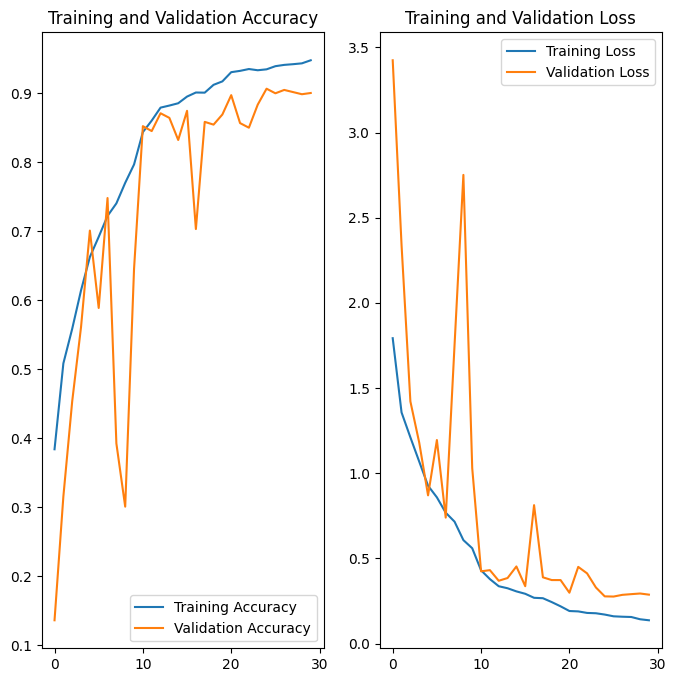

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Yes the class is rebalanced significantly compared to previous runs. Overall accuracy is also increased to 86% and validation accuracy increased to 80%. The gap between train and test accuracy reduced also significantly.

We used Dropout percentage from 25% to 40-50 % and used BatchNormalization also which helped in optimization of the training process and reduce overfitting .
An overall accuracy of 86% and a validation accuracy of 80% do not inherently indicate overfitting. So we can say we got rid of overfitting and this model is good for prediction.
